In [1]:
import pandas as pd
import numpy as np
import ast

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn, optim
from torchvision import datasets, utils, models
# from torchinfo import summary
import torch.nn.functional as F
from torchvision.transforms import v2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import altair as alt
alt.data_transformers.enable("vegafusion")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import multiprocessing

In [2]:
# Change csv name as needed
labels_extended = pd.read_csv('data/selected_gene_df.csv')
clean_possible_genes = labels_extended.columns.to_list()[7:]
num_labels = len(clean_possible_genes)

In [ ]:
train_df, test_df = train_test_split(labels_extended, train_size=0.85, random_state=123)
# test_df.set_index('index', inplace=True)
print(f'Shape of trainset: {train_df.shape}')
print(f'Shape of testset: {test_df.shape}')

Shape of trainset: (41416, 37)
Shape of testset: (7309, 37)


In [4]:
class PythonGeneDataset(Dataset):
    def __init__(self, labels_df, img_dir, indices=None, transform=None):
        self.labels_df = labels_df
        if indices is not None:
            self.labels_df = self.labels_df.iloc[indices]
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.labels_df.iloc[idx, 0]}.png")
        image = Image.open(img_name)
        # Parse labels here based on your CSV structure and required format
        labels = torch.tensor(self.labels_df.iloc[idx, 7:].astype('float32').values)
        
        if self.transform:
            image = self.transform(image)

        return image, labels


In [5]:
IMAGE_SIZE = 480

new_layers = nn.Sequential(
    nn.LazyLinear(2048),  
    nn.BatchNorm1d(2048),
    nn.ReLU(),             
    nn.Dropout(0.5),       
    nn.LazyLinear(num_labels)
)

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToDtype(torch.float16, scale=True),
    # v2.Normalize(mean=[0.6007, 0.5679, 0.5206], std=[0.2411, 0.2392, 0.2479])
    ])

# If using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

full_dataset = PythonGeneDataset(labels_df=train_df, img_dir='data/img/', transform=transform)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = total_size - train_size
generator1 = torch.Generator(device='cpu').manual_seed(42)
train_indices, valid_indices = torch.utils.data.random_split(
    np.arange(total_size),
    [train_size, valid_size],
    generator=generator1
    )
train_indices, valid_indices = torch.utils.data.random_split(np.arange(total_size), [train_size, valid_size])

# Create train and validation datasets
train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)

# Initialize DataLoaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=multiprocessing.cpu_count())
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=multiprocessing.cpu_count())

/opt/conda/envs/deep-learning/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


cuda


## Predictions

In [15]:
efficientnet = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
efficientnet.classifier = new_layers

checkpoint = torch.load(f'model/model_v11_epoch20.pt', map_location=device)
efficientnet.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']

efficientnet.eval()

efficientnet.half().to(device)
print(f"{train_loss:.6f}, {valid_loss:.6f}")

0.010198, 0.008756


True Morphs: ['Pastel', 'Hypo']


,predictions
Pinstripe,0.899414
Pastel,0.643555


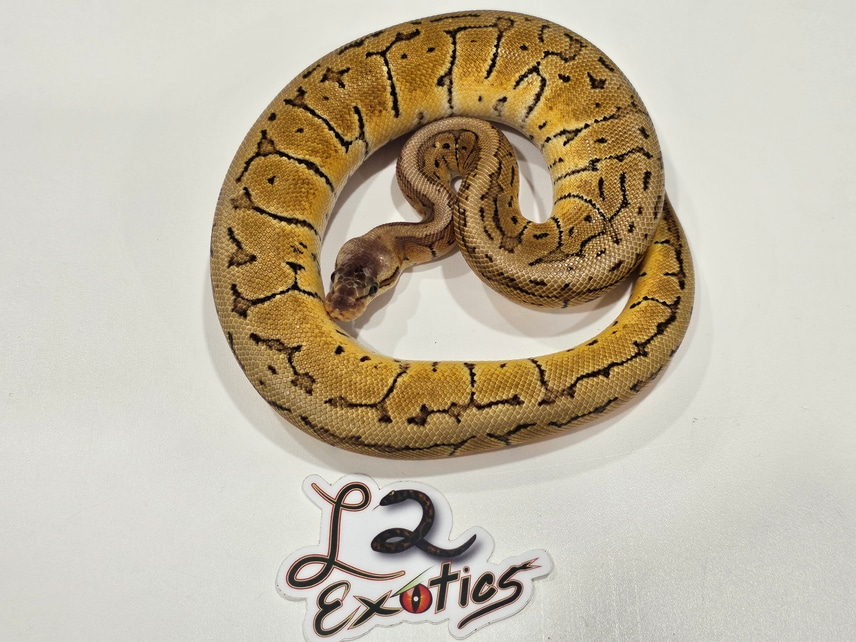

In [23]:
# Prediction from Test set
img_code = np.random.choice(test_df.index)
img = Image.open(f'data/img/{img_code}-0.png')
input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)


with torch.no_grad():
    output = efficientnet(input_img)

predicted_probs = torch.sigmoid(output).to('cpu')
prediction = pd.DataFrame(predicted_probs, index=['predictions'],
                          columns=clean_possible_genes).T.sort_values(by=['predictions'], ascending=False)

print(f'True Morphs: {test_df.loc[img_code, "genes"]}')
display(prediction.query('predictions > 0.5'))
img

Predictions for all the pictures for a listing

In [8]:
# Does not work because of random train test split

# img_code = np.random.choice(test_df.index)
# img_code_parent = img_code.split("-")[0]
# test_df.index[test_df.index.astype(str).str.contains(fr'^{img_code_parent}-')].to_list()

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [25]:
# Loss on test set
test_dataset = PythonGeneDataset(labels_df=test_df, img_dir='data/img/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
focal_loss = FocalLoss()
criterion = focal_loss

efficientnet.eval()  # Set model to evaluate mode

test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

# Calculate average loss over validation data
test_loss = test_loss / len(test_loader.dataset)
print(f'Loss on Test set: {test_loss:.5f}')

KeyboardInterrupt: 

In [34]:
# Prediction on the whole test set
test_df_pred = {}

for img_code in test_df["index"]:
    img = Image.open(f'data/img/{img_code}.png')
    input_img = transform(img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)

    with torch.no_grad():
        output = efficientnet(input_img)

    predicted_probs = torch.sigmoid(output).to('cpu')
    test_df_pred[img_code] = predicted_probs

In [35]:
pred_df = {key: val.numpy().flatten() for key, val in test_df_pred.items()}
pred_df = pd.DataFrame.from_dict(pred_df, orient='index', columns=clean_possible_genes)
pred_df_round = pred_df.round()

In [57]:
pred_df_round

,Pastel,Yellow Belly,Enchi,Clown,Leopard,Piebald,Orange Dream,Fire,Mojave,Pinstripe,...,Desert Ghost,Black Head,Vanilla,Red Stripe,Asphalt,Gravel,Butter,Calico,Albino,Chocolate
27721-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33366-2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10855-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10670-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10220-1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21657-4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4958-1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7064-0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1882-3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def count_matching_elements(list1, list2):
    count = sum(1 for x, y in zip(list1, list2) if x == y)
    return count

count_matching_elements(test_df.query("index == '27721-0'").iloc[0,7:].to_list(), pred_df_round.loc["27721-0"].to_list())

29

In [72]:
result = []
for idx in pred_df_round.index:
    pred = count_matching_elements(test_df.query(f"index == '{idx}'").iloc[0,7:].to_list(), pred_df_round.loc[idx].to_list())
    result.append(pred)
    
for n in range(30, -1, -1):
    print(f'Prediction with {30-n} mistake: {result.count(n) / len(result):.3f}')

Prediction with 0 mistake: 0.278
Prediction with 1 mistake: 0.354
Prediction with 2 mistake: 0.217
Prediction with 3 mistake: 0.099
Prediction with 4 mistake: 0.041
Prediction with 5 mistake: 0.009
Prediction with 6 mistake: 0.002
Prediction with 7 mistake: 0.000
Prediction with 8 mistake: 0.000
Prediction with 9 mistake: 0.000
Prediction with 10 mistake: 0.000
Prediction with 11 mistake: 0.000
Prediction with 12 mistake: 0.000
Prediction with 13 mistake: 0.000
Prediction with 14 mistake: 0.000
Prediction with 15 mistake: 0.000
Prediction with 16 mistake: 0.000
Prediction with 17 mistake: 0.000
Prediction with 18 mistake: 0.000
Prediction with 19 mistake: 0.000
Prediction with 20 mistake: 0.000
Prediction with 21 mistake: 0.000
Prediction with 22 mistake: 0.000
Prediction with 23 mistake: 0.000
Prediction with 24 mistake: 0.000
Prediction with 25 mistake: 0.000
Prediction with 26 mistake: 0.000
Prediction with 27 mistake: 0.000
Prediction with 28 mistake: 0.000
Prediction with 29 mista